In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
strength = pd.read_csv('data/monthly-sutter-county-workforce.csv', index_col=0, parse_dates=True)
strength = strength['Sutter county workforce']
strength.index = pd.DatetimeIndex(strength.index, freq='MS')

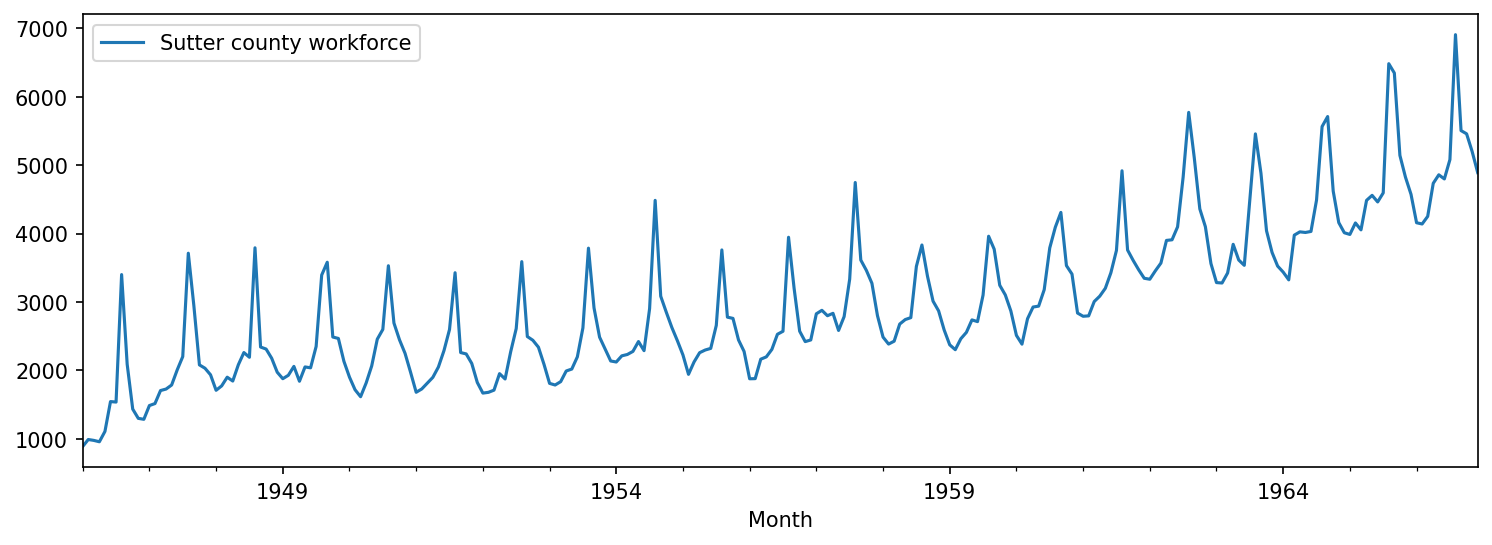

In [19]:
plt.figure(figsize=(12, 4), dpi=150)
strength.plot(legend=True)
plt.show()

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tools.eval_measures import mse

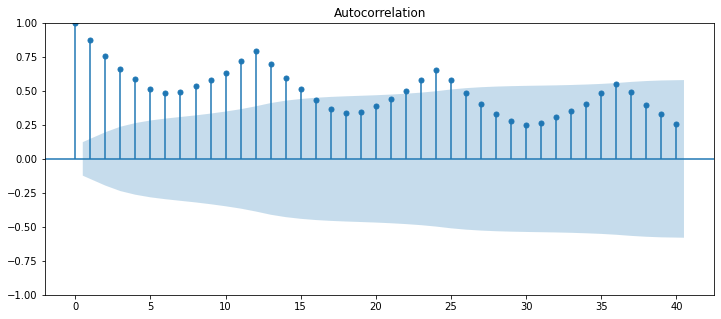

In [23]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(strength, lags=40, ax=ax)
plt.show()

Из коррелограммы видна сезонность. Тренд есть. Попробуем подобрать адаптивную модель, которая будет давать наименьшую среднеквадратичную ошибку

Сначала попробуем модель Хольта-Уинтерса (ExponentialSmoothing) аддитивный случай

In [44]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import mse

In [45]:
holt_winters_add = ExponentialSmoothing(strength, trend='additive', seasonal='additive', initialization_method='estimated').fit()
holt_winters_add.model.params

{'smoothing_level': 0.3576313457969738,
 'smoothing_trend': 0.021011880182460658,
 'smoothing_seasonal': 0.14110357355946682,
 'damping_trend': nan,
 'initial_level': 1435.0069329953399,
 'initial_trend': 16.38969059653632,
 'initial_seasons': array([-404.58281415, -426.10344461, -347.18107465, -375.00798246,
        -209.21672006,  -31.30913748,   33.55288409, 1513.61816626,
         663.23383083,   -8.2833828 , -113.84050584, -296.15729656]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Как можно видеть ошибка велика, но на графики похожи

In [46]:
mse(strength, holt_winters_add.fittedvalues)

58404.4313059445

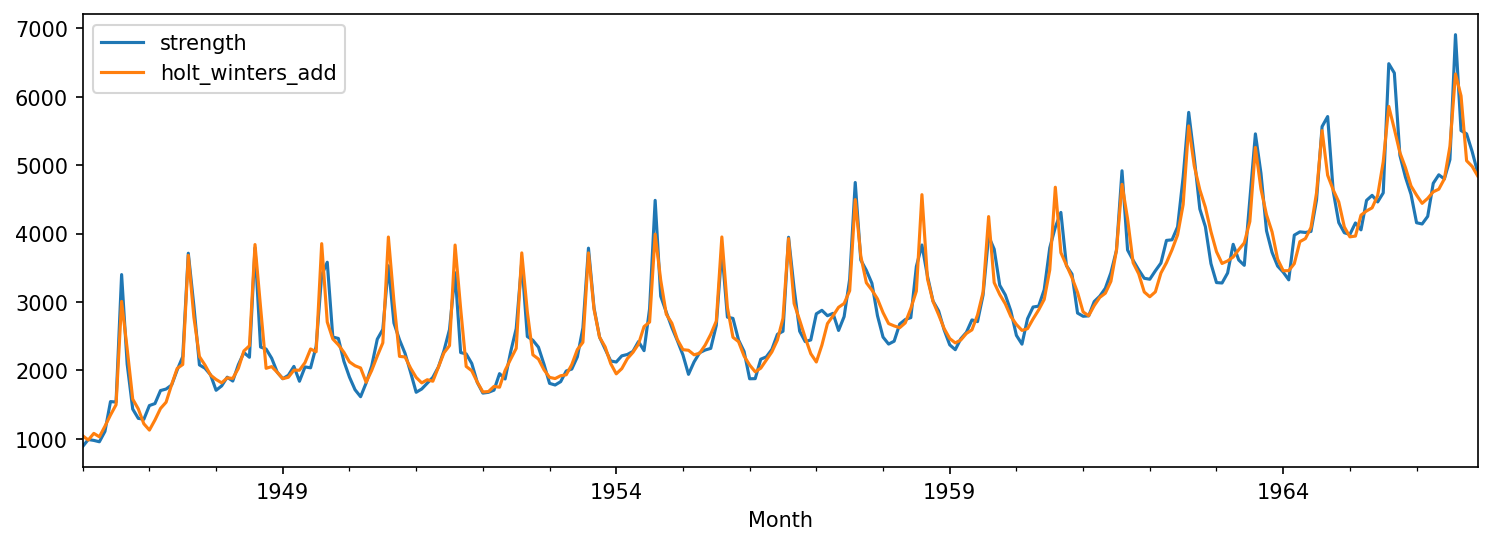

In [47]:
plt.figure(figsize=(12,4), dpi=150)
strength.plot(label='strength')
holt_winters_add.fittedvalues.plot(label='holt_winters_add')
plt.legend(loc='upper left')
plt.show()

In [69]:
start = strength.index[-1]
end = start + pd.DateOffset(years=5)
start, end

(Timestamp('1966-12-01 00:00:00', freq='MS'), Timestamp('1971-12-01 00:00:00'))

In [70]:
holt_winters_add_predict = holt_winters_add.predict(start=start, end=end)

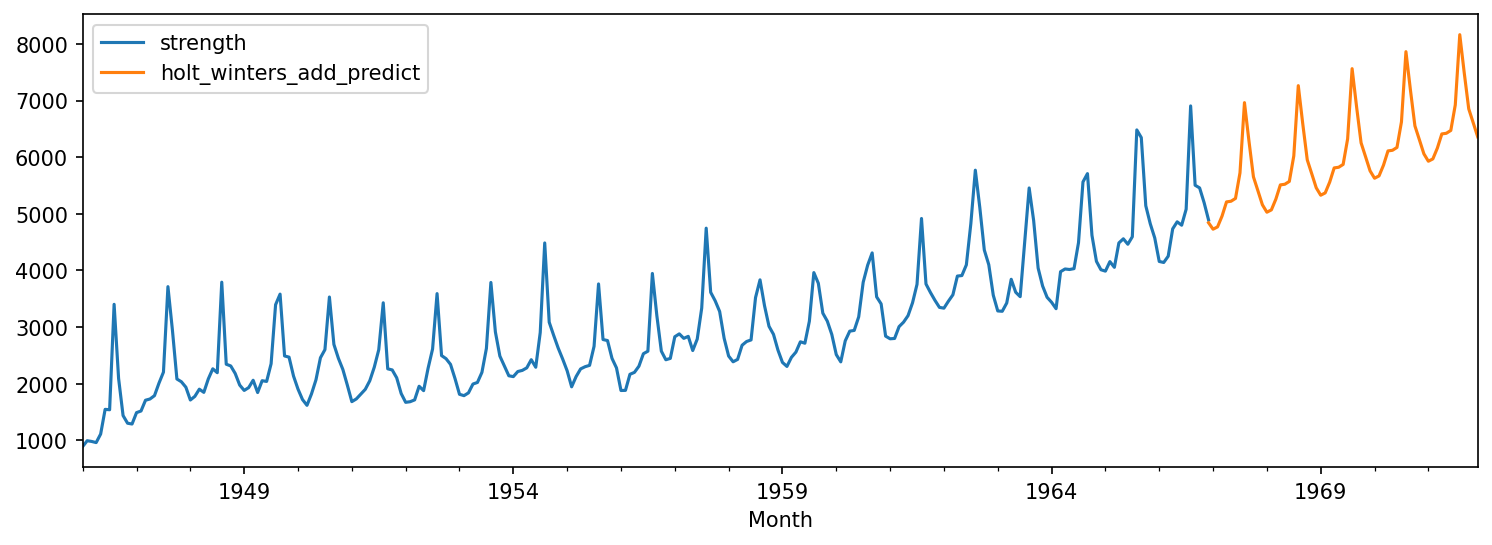

In [71]:
plt.figure(figsize=(12,4), dpi=150)
strength.plot(label='strength')
holt_winters_add_predict.plot(label='holt_winters_add_predict')
plt.legend(loc='upper left')
plt.show()

Теперь мультипликативный

In [41]:
holt_winters_mul = ExponentialSmoothing(strength, trend='mul', seasonal='mul', initialization_method='estimated').fit()
holt_winters_mul.model.params

D:\ForecastingMethods\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


{'smoothing_level': 0.32321432104723163,
 'smoothing_trend': 0.06060269890651961,
 'smoothing_seasonal': 0.29425466299373765,
 'damping_trend': nan,
 'initial_level': 1436.2860647904565,
 'initial_trend': 1.0445875759107281,
 'initial_seasons': array([0.84307408, 0.84478126, 0.87944235, 0.85901022, 0.90053441,
        0.98288321, 1.01232658, 1.76975491, 1.31168771, 1.08714643,
        1.02466183, 0.92206398]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Ошибка стала ещё больше

In [42]:
mse(strength, holt_winters_mul.fittedvalues)

70400.58785589263

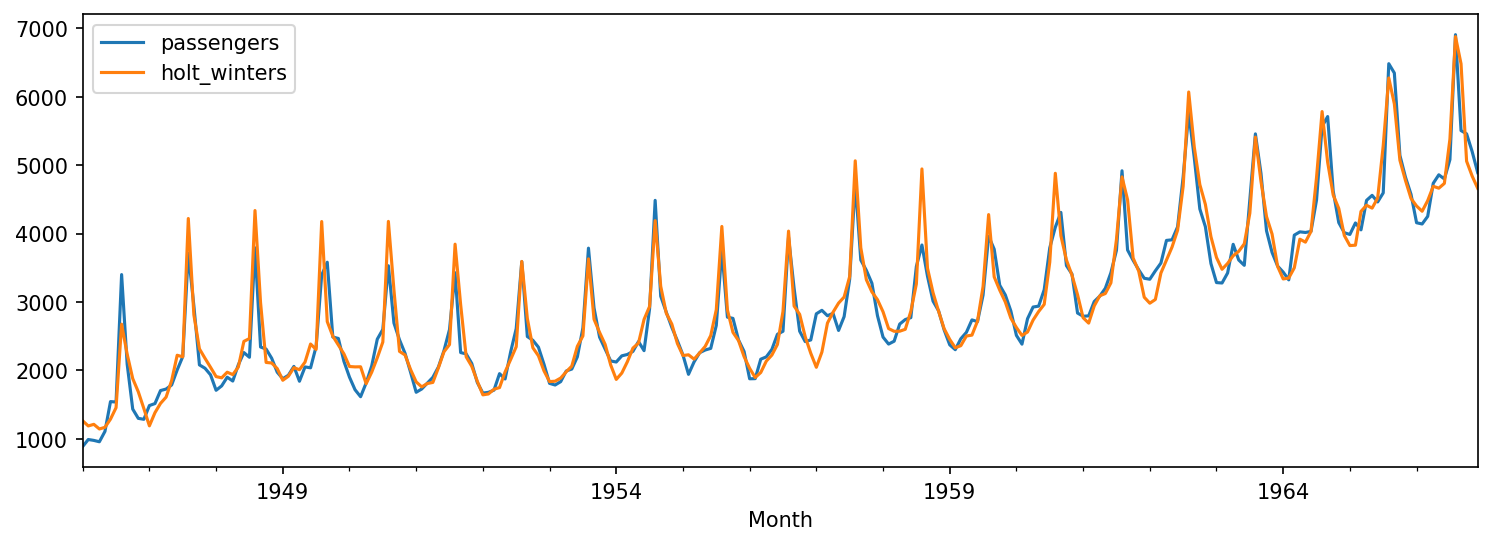

In [43]:
plt.figure(figsize=(12,4), dpi=150)
strength.plot(label='strength')
holt_winters_mul.fittedvalues.plot(label='holt_winters_mul')
plt.legend(loc='upper left')
plt.show()

In [72]:
holt_winters_mul_predict = holt_winters_mul.predict(start=start, end=end)

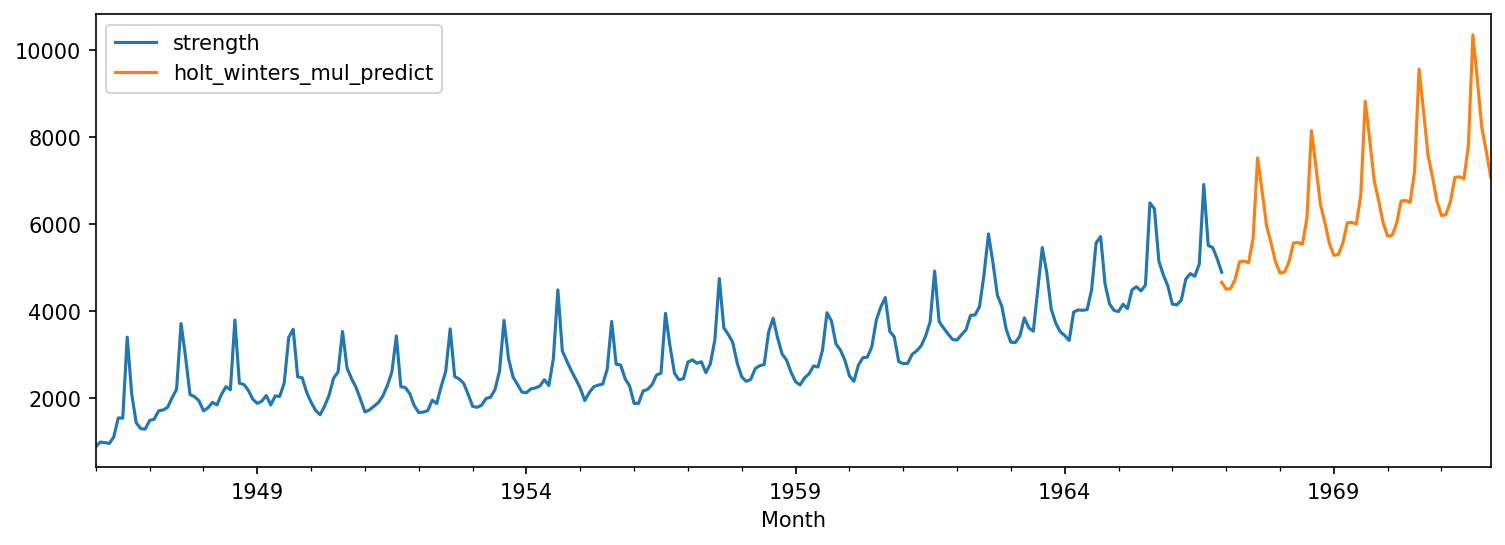

In [73]:
plt.figure(figsize=(12,4), dpi=150)
strength.plot(label='strength')
holt_winters_mul_predict.plot(label='holt_winters_mul_predict')
plt.legend(loc='upper left')
plt.show()

Так же я рассмотрел различные значения trend и seasonal, когда одно add, а другое mul и наоборот. В итоге наименьшее mse было при аддитивном тренде и аддитивной сезонности.

In [88]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [89]:
Bryan_method = SimpleExpSmoothing(strength, initialization_method='estimated').fit()

In [90]:
mse(strength, Bryan_method.fittedvalues)

278209.5096535537

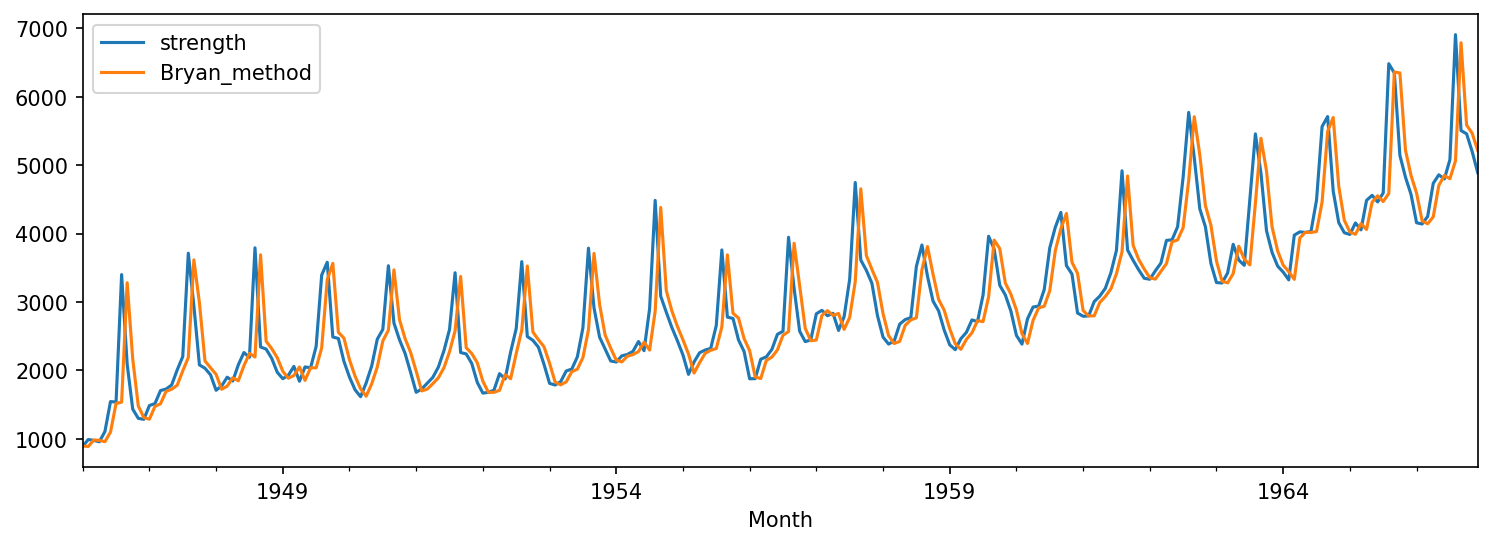

In [91]:
plt.figure(figsize=(12,4), dpi=150)
strength.plot(label='strength')
Bryan_method.fittedvalues.plot(label='Bryan_method')
plt.legend(loc='upper left')
plt.show()

In [94]:
from statsmodels.tsa.holtwinters import Holt

In [95]:
holt = Holt(strength, initialization_method='estimated').fit()

In [96]:
mse(strength, Bryan_method.fittedvalues)

278209.5096535537

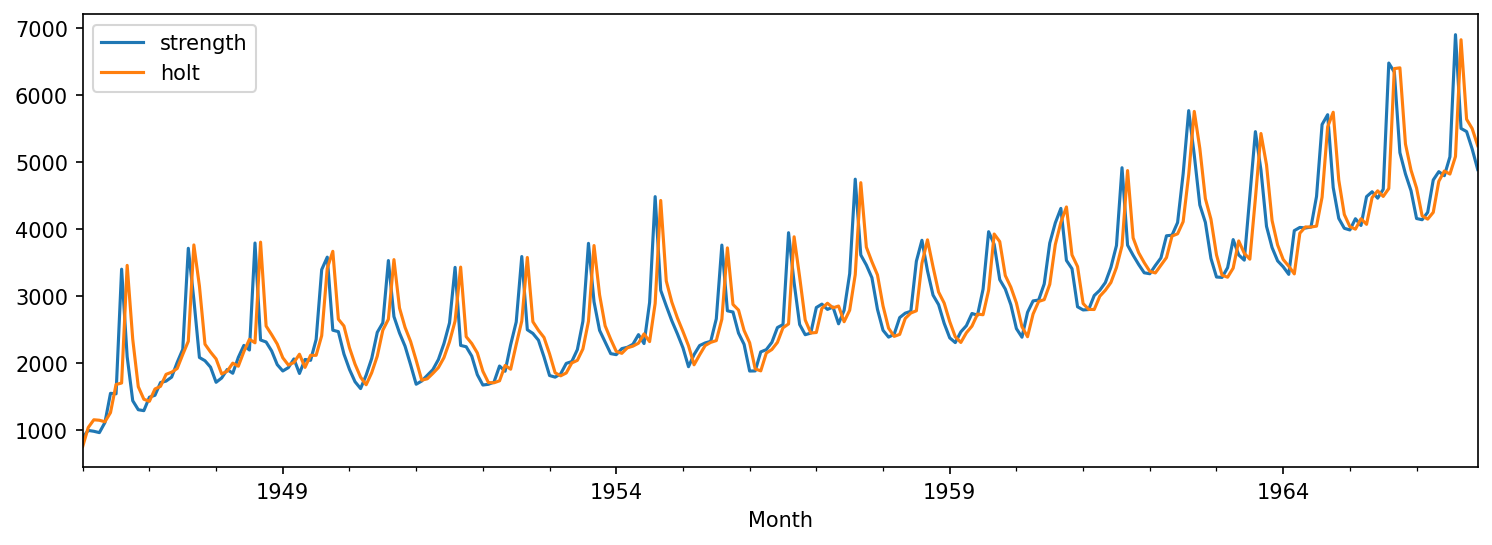

In [97]:
plt.figure(figsize=(12,4), dpi=150)
strength.plot(label='strength')
holt.fittedvalues.plot(label='holt')
plt.legend(loc='upper left')
plt.show()

Наилучшей моделью оказалас модель Хольта-Уинтерса с аддитивной сезонностью и аддитивным трендом 